In [ ]:
!pip install swig
!pip install gymnasium[box2d]


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 25.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376101 sha256=33eeead0895330a5c6da629ad569a9904fb690f4cc39af4c64452c007eb909b1
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


In [ ]:
import gymnasium as gym
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt

# Initialize the Bipedal Walker environment
env = gym.make('BipedalWalker-v3') #, render_mode="human")

# Get the observation and action space
obs = env.observation_space
act = env.action_space

print(f"Observation Space: {obs}")
print(f"Action Space: {act}")


Observation Space: Box([-3.1415927 -5.        -5.        -5.        -3.1415927 -5.
 -3.1415927 -5.        -0.        -3.1415927 -5.        -3.1415927
 -5.        -0.        -1.        -1.        -1.        -1.
 -1.        -1.        -1.        -1.        -1.        -1.       ], [3.1415927 5.        5.        5.        3.1415927 5.        3.1415927
 5.        5.        3.1415927 5.        3.1415927 5.        5.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.       ], (24,), float32)
Action Space: Box(-1.0, 1.0, (4,), float32)


In [ ]:
class QTableLearning:
    def __init__(self, env, obs_buckets=10, act_buckets=5, episodes=5000, max_steps = 10000, gamma=0.99, alpha=0.1, epsilon=1.0, mode='uniform'):
        """
        Initialize the Q-learning agent.

        Parameters:
        env (gym.Env): The environment to be used.
        obs_buckets (int): Number of discrete buckets per dimension in the observation space in uniform mode. Buckets per unity in range mode.
        act_buckets (int): Number of discrete actions per dimension in the action space.
        episodes (int): Number of episodes for training.
        gamma (float): Discount factor.
        alpha (float): Learning rate.
        epsilon (float): Initial exploration rate.
        mode (str): Discretization mode, 'uniform' or 'range'.
        """
        self.env = env
        self.obs_buckets = obs_buckets
        self.act_buckets = act_buckets
        self.episodes = episodes
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.qtable = defaultdict(lambda: np.zeros(tuple([act_buckets] * len(self.env.action_space.low))))
        self.obs = env.observation_space
        self.act = env.action_space
        self.mode = mode
        self.max_steps = max_steps

    def discretizeState(self, state):
        """
        Discretize the continuous observation state into discrete buckets based on the mode.

        Parameters:
        state (np.array): Continuous observation state.

        Returns:
        tuple: Discretized state.
        """
        if self.mode == 'uniform':
            discrete_state = np.round((state - self.obs.low) / (self.obs.high - self.obs.low) * (self.obs_buckets - 1)).astype(int)
        elif self.mode == 'range':
            discrete_state = []
            for i, val in enumerate(state):
                # compute the number of buckets for each dimension
                bucket_size = (self.obs.high[i] - self.obs.low[i]) * self.obs_buckets
                # make sure that there is at least one bucket for each dimension
                bucket_size = max(1, int(bucket_size))
                #discretize the dimension
                discrete_val = round((val - self.obs.low[i]) / (self.obs.high[i] - self.obs.low[i]) * (bucket_size - 1))
                discrete_state.append(discrete_val)
        else:
            raise ValueError(f"Invalid mode '{self.mode}'. Supported modes are 'uniform' and 'range'.")

        return tuple(discrete_state)

    def discretizeAction(self, action):
        """
        Discretize the continuous action into discrete buckets.

        Parameters:
        action (np.array): Continuous action.

        Returns:
        tuple: Discretized action.
        """
        discrete_action = np.round((action - self.act.low) / (self.act.high - self.act.low) * (self.act_buckets - 1)).astype(int)
        return tuple(discrete_action)

    def undiscretizeAction(self, action):
        """
        Convert a discrete action back into a continuous action.

        Parameters:
        action (tuple): Discretized action.

        Returns:
        tuple: Continuous action.
        """
        action = (action / (self.act_buckets - 1)) * (self.act.high - self.act.low) + self.act.low
        return tuple(action)

    def epsilonGreedyStrategy(self, state):
        """
        Choose an action using the epsilon-greedy strategy.

        Parameters:
        state (tuple): Current discretized state.

        Returns:
        np.array: Chosen action.
        """
        if random.random() < self.epsilon:
            # Exploration: choose a random action
            action = np.random.randint(0, self.act_buckets, size=self.act.shape)
        else:
            # Exploitation: choose the action with the highest Q value
            flat_best_action_index = np.argmax(self.qtable[state])
            action = np.array(np.unravel_index(flat_best_action_index, self.qtable[state].shape))
        return action

    def updateQTable(self, state, action, reward, next_state):
        """
        Update the Q-table using the Q-learning update rule.

        Parameters:
        state (tuple): Current discretized state.
        action (tuple): Discretized action taken.
        reward (float): Reward received.
        next_state (tuple): Next discretized state.
        """
        q_sa = self.qtable[state][action]
        max_next_value = np.max(self.qtable[next_state]) if next_state in self.qtable else 0
        new_value = q_sa * (1 - self.alpha) + self.alpha * (reward + self.gamma * max_next_value)
        self.qtable[state][action] = new_value

    def learn(self):
        """
        Train the Q-learning agent over the specified number of episodes.
        """
        rewards = []  # List to store total rewards for each episode
        for episode in range(1, self.episodes + 1):
            total_reward = 0
            init = self.env.reset()[0]
            state = self.discretizeState(init)
            self.epsilon = max(0.01, self.epsilon * 0.999)
            #self.epsilon = 1.0 / episode

            for j in range(self.max_steps):
                action = self.epsilonGreedyStrategy(state)
                continuous_action = self.undiscretizeAction(action)

                next_state, reward, done, truncated, info = self.env.step(continuous_action)
                #self.env.render()
                next_state = self.discretizeState(next_state)
                action = tuple(action)
                self.updateQTable(state, action, reward, next_state)
                total_reward += reward
                state = next_state

                if done:
                    break

            rewards.append(total_reward)  # Store total reward for this episode
            print(f"Episode {episode}/{self.episodes}, Total Reward: {total_reward}")

        self.env.close()
        max_reward = max(rewards)  # Calculate the maximum reward
        print(f"Maximum Reward: {max_reward}")
        return max_reward, rewards



Output streaming troncato alle ultime 5000 righe.
Episode 2/5000, Total Reward: -107.0565716760084
Episode 3/5000, Total Reward: -102.70947016888671
Episode 4/5000, Total Reward: -107.88287090606181
Episode 5/5000, Total Reward: -351.53076285790996
Episode 6/5000, Total Reward: -187.60136223547335
Episode 7/5000, Total Reward: -103.01806860508583
Episode 8/5000, Total Reward: -109.03630397675373
Episode 9/5000, Total Reward: -482.39063543966
Episode 10/5000, Total Reward: -123.15728945728826
Episode 11/5000, Total Reward: -163.2833462991087
Episode 12/5000, Total Reward: -110.24211045591595
Episode 13/5000, Total Reward: -104.38041277572637
Episode 14/5000, Total Reward: -665.968494600621
Episode 15/5000, Total Reward: -672.113406670586
Episode 16/5000, Total Reward: -121.44499589988092
Episode 17/5000, Total Reward: -99.54664328562531
Episode 18/5000, Total Reward: -167.52518606301652
Episode 19/5000, Total Reward: -99.82778845578866
Episode 20/5000, Total Reward: -97.46923468904322
E

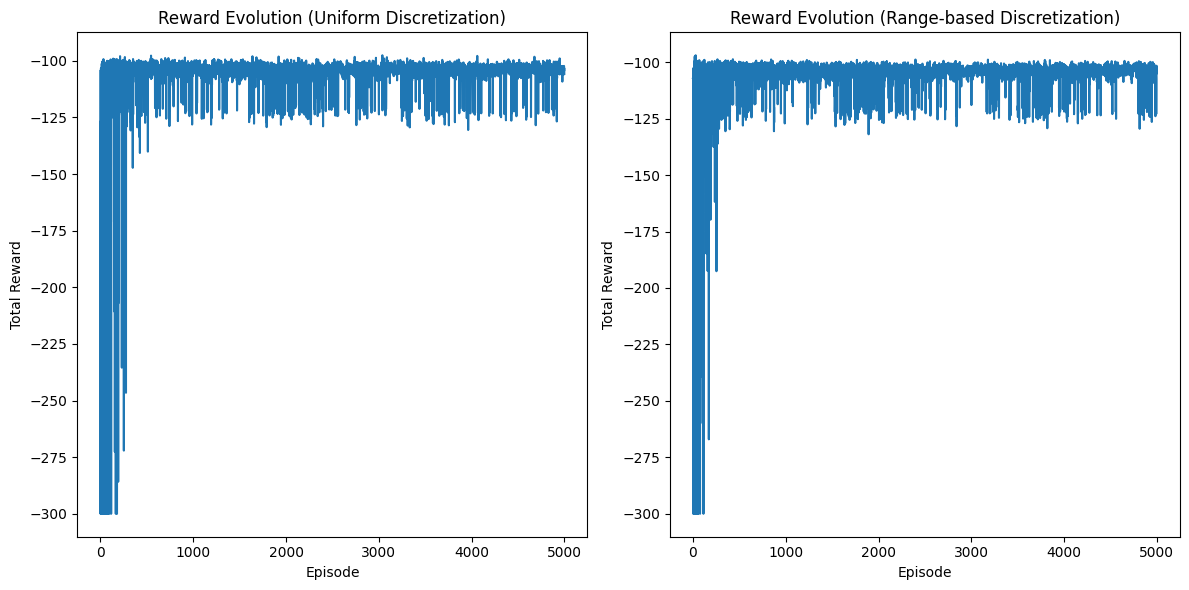

In [ ]:
# Example usage:
#env = gym.make('BipedalWalker-v3')  # Initialize your environment
q_learning_uniform = QTableLearning(env, mode='uniform')  # Initialize Q-learning with uniform discretization
q_learning_range = QTableLearning(env, obs_buckets=2, mode='range')  # Initialize Q-learning with range-based discretization
max_reward_uniform, rewards_uniform = q_learning_uniform.learn()
max_reward_range, rewards_range = q_learning_range.learn()

# Optionally, plot the rewards to observe the evolution (requires matplotlib)
import matplotlib.pyplot as plt

#clamp the rewards for good visualization purpose
rewards_uniform = [r if r >= -300 else -300 for r in rewards_uniform]
rewards_range = [r if r >= -300 else -300 for r in rewards_range]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(rewards_uniform)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Reward Evolution (Uniform Discretization)')

plt.subplot(1, 2, 2)
plt.plot(rewards_range)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Reward Evolution (Range-based Discretization)')

plt.tight_layout()
plt.show()


In [ ]:
import gymnasium as gym
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import imageio
import os

class QTableLearning:
    def __init__(self, env, episodes=10000, gamma=0.9, alpha=0.5, epsilon=1.0):
        self.env = env
        self.episodes = episodes
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.qtable = defaultdict(lambda: np.zeros(env.action_space.n))

    def epsilonGreedyStrategy(self, state):
        if random.random() < self.epsilon:
            action = self.env.action_space.sample()
        else:
            action = np.argmax(self.qtable[state])
        return action

    def updateQTable(self, state, action, reward, next_state):
        q_sa = self.qtable[state][action]
        max_next_value = np.max(self.qtable[next_state])
        new_value = q_sa * (1 - self.alpha) + self.alpha * (reward + self.gamma * max_next_value)
        self.qtable[state][action] = new_value

    def learn(self):
        rewards = []
        for episode in range(1, self.episodes + 1):
            total_reward = 0
            state = self.env.reset()[0]
            self.epsilon = max(0.01, self.epsilon * 0.999)
            frames = []  # List to store frames for GIF creation

            while True:
                action = self.epsilonGreedyStrategy(state)
                next_state, reward, done, truncated, info = self.env.step(action)
                self.updateQTable(state, action, reward, next_state)
                total_reward += reward
                state = next_state

                # Capture frame
                frame = self.env.render(mode='rgb_array')
                frames.append(frame)

                if done:
                    break

            rewards.append(total_reward)
            print(f"Episode {episode}/{self.episodes}, Total Reward: {total_reward}")

            if episode == self.episodes:  # Save GIF only for the last episode
                self.save_gif(frames, 'frozenlake.gif')

        self.env.close()
        max_reward = max(rewards)
        print(f"Maximum Reward: {max_reward}")
        return max_reward, rewards

    def save_gif(self, frames, filename):
        imageio.mimsave(filename, frames, fps=30)

# Utilizzo del Q-learning con l'ambiente FrozenLake
env = gym.make('FrozenLake-v1', is_slippery=True)
q_learning_agent = QTableLearning(env)
max_reward, rewards = q_learning_agent.learn()

plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Reward Evolution Over Episodes')
plt.show()

# Visualizzare la GIF
from IPython.display import Image
Image(filename='frozenlake.gif')


/usr/local/lib/python3.10/dist-packages/gymnasium/envs/toy_text/frozen_lake.py:328: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("FrozenLake-v1", render_mode="rgb_array")
  gym.logger.warn(


Output streaming troncato alle ultime 5000 righe.
Episode 5001/10000, Total Reward: 0.0
Episode 5002/10000, Total Reward: 0.0
Episode 5003/10000, Total Reward: 1.0
Episode 5004/10000, Total Reward: 0.0
Episode 5005/10000, Total Reward: 0.0
Episode 5006/10000, Total Reward: 0.0
Episode 5007/10000, Total Reward: 0.0
Episode 5008/10000, Total Reward: 1.0
Episode 5009/10000, Total Reward: 1.0
Episode 5010/10000, Total Reward: 0.0
Episode 5011/10000, Total Reward: 1.0
Episode 5012/10000, Total Reward: 1.0
Episode 5013/10000, Total Reward: 1.0
Episode 5014/10000, Total Reward: 1.0
Episode 5015/10000, Total Reward: 1.0
Episode 5016/10000, Total Reward: 1.0
Episode 5017/10000, Total Reward: 0.0
Episode 5018/10000, Total Reward: 0.0
Episode 5019/10000, Total Reward: 0.0
Episode 5020/10000, Total Reward: 0.0
Episode 5021/10000, Total Reward: 0.0
Episode 5022/10000, Total Reward: 1.0
Episode 5023/10000, Total Reward: 1.0
Episode 5024/10000, Total Reward: 0.0
Episode 5025/10000, Total Reward: 0.0


AttributeError: 'NoneType' object has no attribute '__array_interface__'

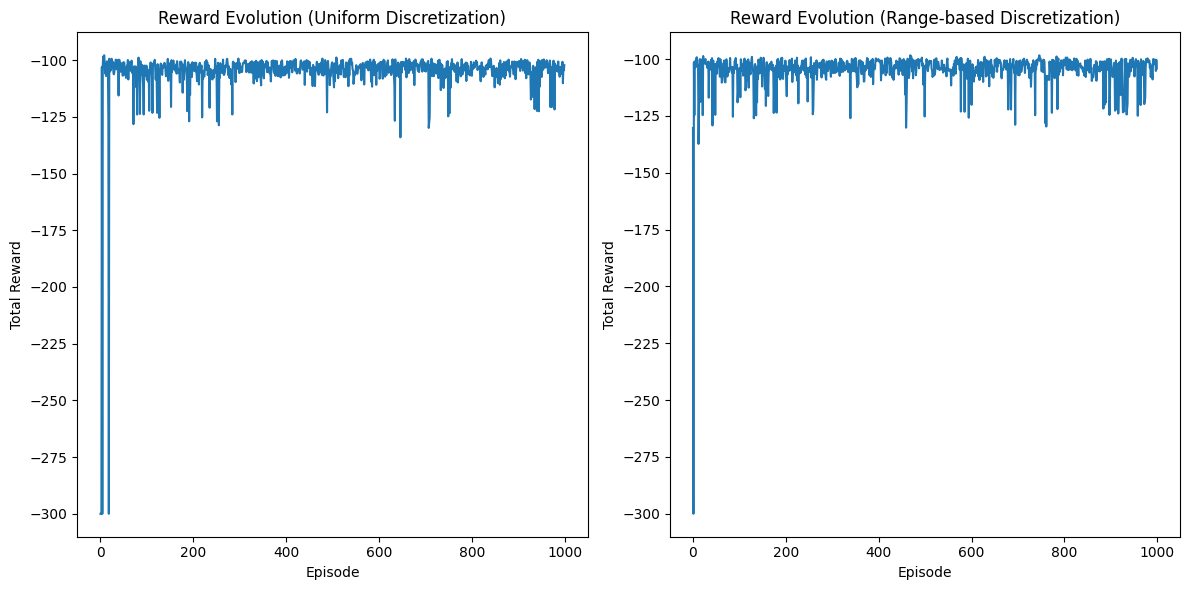

In [ ]:
rewards_uniform = [r if r >= -300 else -300 for r in rewards_uniform]
rewards_range = [r if r >= -300 else -300 for r in rewards_range]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(rewards_uniform)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Reward Evolution (Uniform Discretization)')

plt.subplot(1, 2, 2)
plt.plot(rewards_range)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Reward Evolution (Range-based Discretization)')

plt.tight_layout()
plt.show()


In [ ]:
#env = gym.make('BipedalWalker-v3')  # Initialize your environment
q_learning = QTableLearning(env, obs_buckets = 2, mode =  'range')
max_reward, rewards = q_learning.learn()

# Optionally, plot the rewards to observe the evolution (requires matplotlib)
import matplotlib.pyplot as plt

plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Reward Evolution Over Episodes')
plt.show()


Output streaming troncato alle ultime 5000 righe.
4.0 2.0
4
4.0 2.0
4
4.0 2.0
4
[ 1.4362279e+00  2.2402864e-02 -1.4189718e-02 -4.6485666e-02
 -7.8488320e-01 -1.5305370e-01 -6.3499022e-01 -5.6122925e-02
  1.0000000e+00 -8.2331604e-01 -7.7323616e-04 -6.4166033e-01
 -1.5401758e-01  1.0000000e+00  3.1057587e-01  3.1410295e-01
  3.2509580e-01  3.4491298e-01  3.7630251e-01  4.2446440e-01
  4.9963143e-01  6.2418401e-01  8.5709739e-01  1.0000000e+00]
[8, 10, 9, 9, 4, 9, 4, 9, 2, 4, 9, 4, 9, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3]
12.566370964050293 6.2831855
12
20.0 10.0
20
20.0 10.0
20
20.0 10.0
20
12.566370964050293 6.2831855
12
20.0 10.0
20
12.566370964050293 6.2831855
12
20.0 10.0
20
10.0 5.0
10
12.566370964050293 6.2831855
12
20.0 10.0
20
12.566370964050293 6.2831855
12
20.0 10.0
20
10.0 5.0
10
4.0 2.0
4
4.0 2.0
4
4.0 2.0
4
4.0 2.0
4
4.0 2.0
4
4.0 2.0
4
4.0 2.0
4
4.0 2.0
4
4.0 2.0
4
4.0 2.0
4
[ 1.44379771e+00  1.52429985e-02 -1.32311322e-02  2.13241205e-02
 -7.93007910e-01 -5.61899655e-02 -6.272

KeyboardInterrupt: 

In [ ]:
total_states = 1e12
def calculate_obs_buckets():
        """
        Calculate the number of buckets for each dimension in the observation space
        such that the total number of discrete states is approximately equal to the desired total_states.

        Returns:
        list: Number of buckets for each dimension.
        """
        obs_dim = len(obs.low)
        buckets_per_dim = int(round(total_states ** (1 / obs_dim)))
        return [buckets_per_dim] * obs_dim
print(calculate_obs_buckets())

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [ ]:
for episode in range(1, episodes + 1):
    total_reward = 0
    init = env.reset()[0]
    state = discretizeState(init)  # Reset dell'environment e discretizzazione dello stato iniziale
    epsilon = 1.0/episodes  # Calcolo del valore epsilon per l'epsilon-greedy strategy

    while True:
        action = epsilonGreedyStrategy(qtable, epsilon, state)  # Selezione dell'azione usando la strategia epsilon-greedy
        continuous_action = undiscretizeAction(action)

        next_state, reward, done, truncated, info = env.step(continuous_action)  # Esecuzione dell'azione nel environment

        next_state = discretizeState(next_state)  # Discretizzazione del prossimo stato
        action = tuple(action)
        updateQTable(qtable, state, action, reward, next_state)  # Aggiornamento della Q-table
        total_reward += reward  # Aggiornamento della ricompensa totale
        state = next_state  # Passaggio allo stato successivo

        if done:
            break

    # Stampa della ricompensa totale di ogni episodio
    print(f"Episode {episode}/{episodes}, Total Reward: {total_reward}")

# Close the environment
env.close()

Episode 1/10000, Total Reward: -101.58378074409089
Episode 2/10000, Total Reward: -144.49624309135288
Episode 3/10000, Total Reward: -101.08297441289864
Episode 4/10000, Total Reward: -101.33267605988102
Episode 5/10000, Total Reward: -101.08669024970776
Episode 6/10000, Total Reward: -101.11505787293986
Episode 7/10000, Total Reward: -101.30026276934002
Episode 8/10000, Total Reward: -104.95009796253468
Episode 9/10000, Total Reward: -101.4757148174002
Episode 10/10000, Total Reward: -106.86069052189963
Episode 11/10000, Total Reward: -101.24928716641003
Episode 12/10000, Total Reward: -108.69415430525237
Episode 13/10000, Total Reward: -108.53209653561046
Episode 14/10000, Total Reward: -106.80622283713707
Episode 15/10000, Total Reward: -106.19200884975412
Episode 16/10000, Total Reward: -108.80179164756339
Episode 17/10000, Total Reward: -107.89550263005931
Episode 18/10000, Total Reward: -107.4233123044262
Episode 19/10000, Total Reward: -106.77653317297232
Episode 20/10000, Total

KeyboardInterrupt: 

In [ ]:
qtable[discrete_observation] = np.random.uniform(low=act.low, high=act.high, size=act.shape)
print(qtable[discrete_observation])
print(np.argmax(qtable[discrete_observation]))
print(qtable[discrete_observation].shape)
print(np.unravel_index(np.argmax(qtable[discrete_observation]), qtable[discrete_observation].shape))

In [ ]:
print((qtable[tuple(np.zeros(24))]).size, (qtable[tuple(np.zeros(24))]).shape)

In [ ]:
print(qtable[tuple(np.zeros(24))])

[[[[0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]]]


 [[[0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
